<a href="https://colab.research.google.com/github/itsGab/bootcamp_df_covid_prophet/blob/main/nb/covid_curitiba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[fonte](http://www.coronavirus.pr.gov.br/vacinacao-ranking) da porcentagem de vacinados em curitiba

[boletim epidemiologico covid 19 pr - 2021-06-19](https://www.saude.pr.gov.br/sites/default/arquivos_restritos/files/documento/2021-06/informe_epidemiologico_19_06_2021.pdf)

# Preparo dos dados

Importacão dos pacotes

In [194]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fbprophet import Prophet
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error
from fbprophet.diagnostics import cross_validation

Abrindo os dados

In [195]:
dados = '/content/drive/MyDrive/Bootcamp Data Science Aplicada 2 Alura/dados full covid 19/caso_full.csv'
covid = pd.read_csv(dados)

Mudando o nome das colunas e fazendo o tratamento

In [196]:
traduz = {
    'city': 'cidade', 
    'city_ibge_code': 'cod_ibge_cidade', 
    'date': 'datahora', 
    'epidemiological_week': 'semana_epidemiologica',
    'estimated_population': 'populacao_estimada', 
    'estimated_population_2019': 'populacao_estimada_2019', 
    'is_last': 'eh_ultimo',
    'is_repeated': 'eh_repetido', 
    'last_available_confirmed': 'ultimo_disponivel_confirmado',
    'last_available_confirmed_per_100k_inhabitants': 'ultimo_disponivel_confirmado_por_100mil_habitantes', 
    'last_available_date': 'ultimo_disponivel_datahora',
    'last_available_death_rate': 'ultimo_disponivel_taxa_mortalidade', 
    'last_available_deaths': 'ultimo disponivel obitos', 
    'order_for_place': 'ordem_por_lugar',
    'place_type': 'tipo_de_lugar', 
    'state': 'estado', 
    'new_confirmed': 'casos_novos', 
    'new_deaths': 'obitos_novos'
}

covid.columns = covid.columns.map(traduz)
covid['tipo_de_lugar'] = covid['tipo_de_lugar'].map(traduz)
covid['datahora'] = pd.to_datetime(covid['datahora'])
covid['mes'] = covid['datahora'].dt.month
covid['dia'] = covid['datahora'].dt.day
covid['ano'] = covid['datahora'].dt.year

Selecionando Curitiba e adicionando colunas para usar nas analise e previsões

In [197]:
# só Curitiba PR
ctba = covid[covid['cidade'] == 'Curitiba']
# acumulado
ctba['casos_acumulados'] = ctba['casos_novos'].cumsum() 
# média móvel 7 dias
ctba['casos_media_movel'] = ctba['casos_novos'].rolling(7, center=False).mean() 
# para datetime
ctba['datahora'] = pd.to_datetime(ctba['datahora']) 

# Plotando os primeiros gráficos | Analiticos

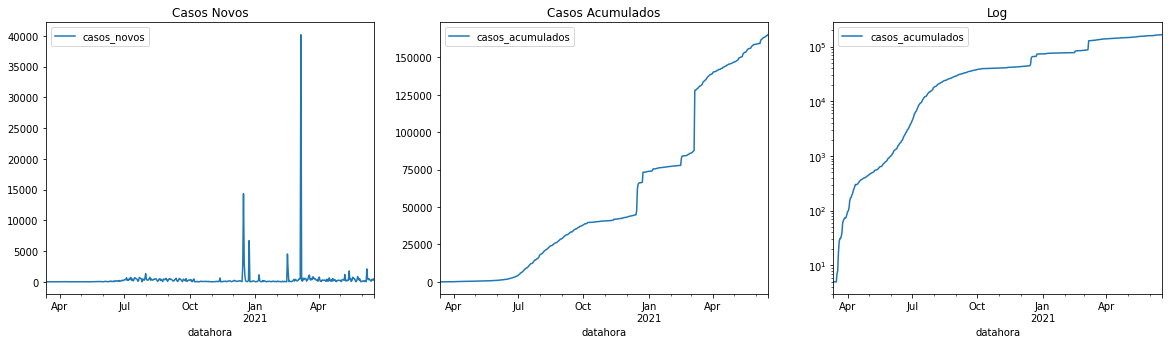

In [198]:
fig, ax = plt.subplots(1,3, figsize=(20, 5))

ctba.plot('datahora', 'casos_novos', ax=ax[0], title='Casos Novos')
ctba.plot('datahora', 'casos_acumulados', ax=ax[1], title='Casos Acumulados')
ctba.plot('datahora', 'casos_acumulados', ax=ax[2], title='Log')
mpl.pyplot.yscale('log')

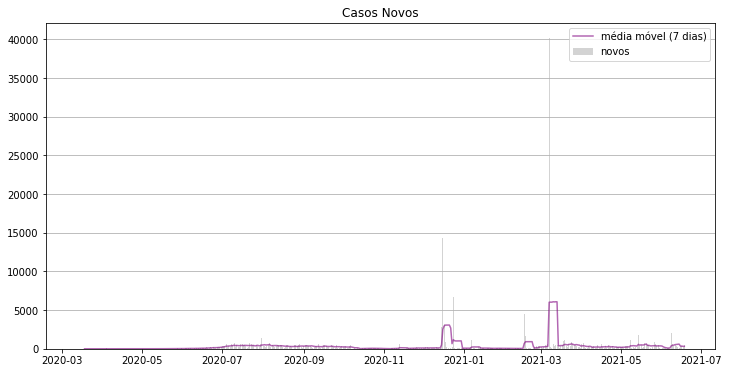

In [199]:
plt.figure(figsize=(12,6))
plt.bar('datahora', 'casos_novos', data=ctba, color='lightgrey', label='novos')
plt.plot('datahora', 'casos_media_movel', data=ctba, color='purple', label='média móvel (7 dias)', alpha=0.6)
plt.ylim(0)
plt.grid(axis='y')
plt.legend()
plt.title('Casos Novos')
plt.show()

O grafico tem valores muito fora da curva no periodos proximo a dezembro de 2020 e março de 2021, isso pode ser por causa de casos que foram registrados atrasados nessa data.

Plotando novamente o gráfico anterior em uma escala menor para que seja possível ver a variação no numero de casos novos e na médio móvel

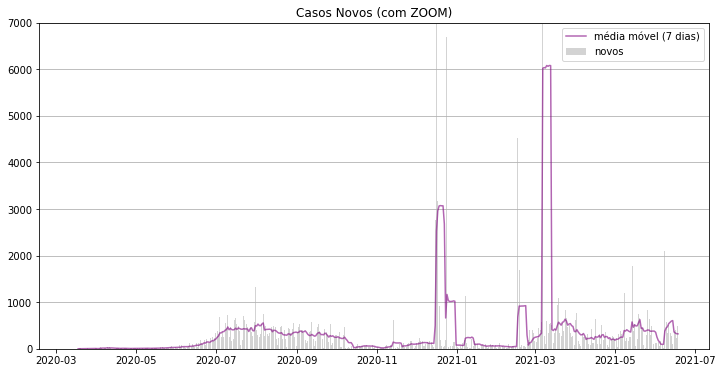

In [200]:
plt.figure(figsize=(12,6))
plt.bar('datahora', 'casos_novos', data=ctba, color='lightgrey', label='novos')
plt.plot('datahora', 'casos_media_movel', data=ctba, color='purple', label='média móvel (7 dias)', alpha=0.6)
plt.ylim(0, 7000)
plt.grid(axis='y')
plt.legend()
plt.title('Casos Novos (com ZOOM)')
plt.show()

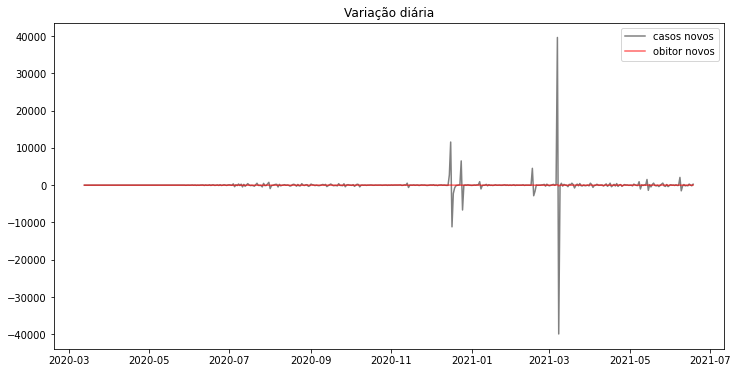

In [201]:
plt.figure(figsize=(12,6))
plt.plot(ctba['datahora'], ctba['casos_novos'].diff(), color='grey', label='casos novos')
plt.plot(ctba['datahora'], ctba['obitos_novos'].diff(), color='red', label='obitor novos', alpha=0.6)
plt.title('Variação diária')
plt.legend()
plt.show()

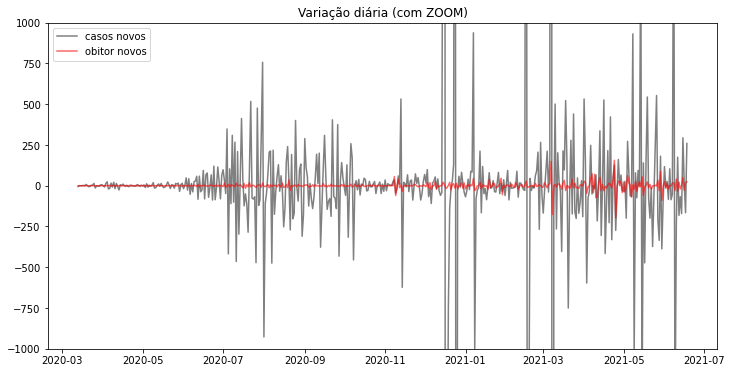

In [202]:
plt.figure(figsize=(12,6))
plt.plot(ctba['datahora'], ctba['casos_novos'].diff(), color='grey', label='casos novos')
plt.plot(ctba['datahora'], ctba['obitos_novos'].diff(), color='red', label='obitor novos', alpha=0.6)
plt.title('Variação diária (com ZOOM)')
plt.ylim(-1000,1000)
plt.legend()
plt.show()

# Funções e DF para o Prophet

In [203]:
def cria_df(df_base, col_ds: str, col_y: str):
    df = pd.DataFrame({'ds': pd.to_datetime(df_base[col_ds]), 'y': df_base[col_y]})
    return df

In [204]:
def cria_modelo(df_prophet, periodo=30, modelo=None):
    if modelo == None:
        modelo = Prophet()
    modelo.fit(df_prophet)
    future = modelo.make_future_dataframe(periodo)
    forcast = modelo.predict(future)
    return modelo, future, forcast

In [205]:
df = cria_df(ctba, 'datahora', 'casos_novos')
df.head()

,ds,y
1300681,2020-03-12,5
1300684,2020-03-13,0
1300687,2020-03-14,0
1300690,2020-03-15,0
1300693,2020-03-16,0


# Outliers e Changepoint Prior Scale

Text(0.5, 1.0, 'Grafico de Novos Casos Completo (com outliers)')

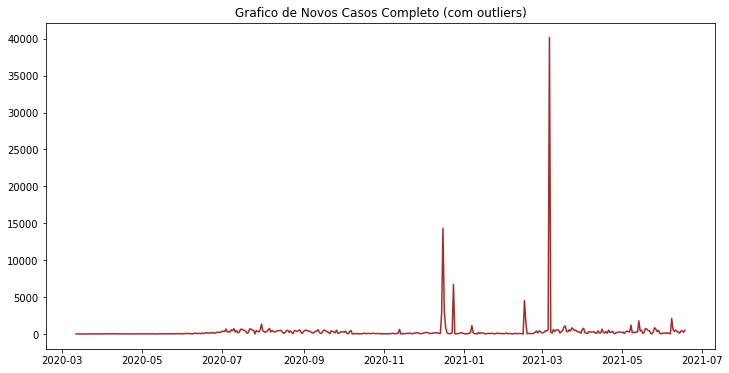

In [206]:
plt.figure(figsize=(12,6))
plt.plot(df['ds'], df['y'], color='brown')
plt.title('Grafico de Novos Casos Completo (com outliers)')

Visualmente, são 4 outliers que se destacam, em especial o do mês 3 (março) de 2021.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(-2500.0, 2500.0)

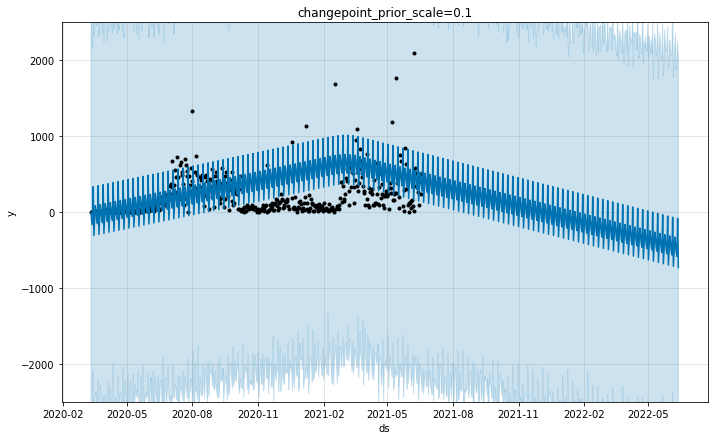

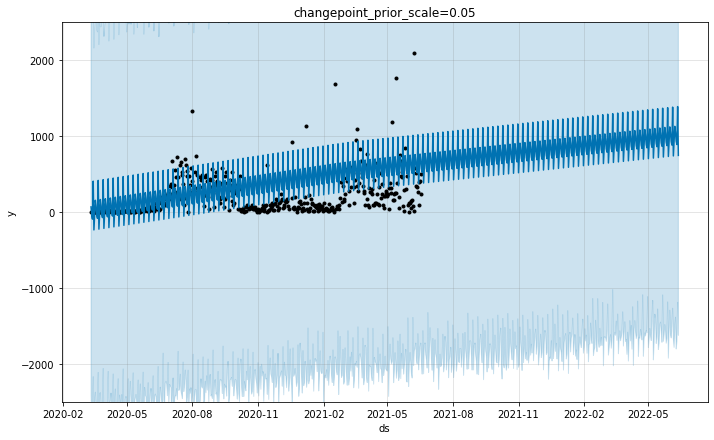

In [207]:
# criar modelo prophet
m = Prophet(changepoint_prior_scale=0.1).fit(df) # 0.1
future = m.make_future_dataframe(360)
fcst = m.predict(future)
m.plot(fcst);
plt.title('changepoint_prior_scale=0.1')
plt.ylim(-2500, 2500)

m = Prophet(changepoint_prior_scale=0.05).fit(df) # 0.05 (padrão)
future = m.make_future_dataframe(360)
fcst = m.predict(future)
m.plot(fcst);
plt.title('changepoint_prior_scale=0.05')
plt.ylim(-2500, 2500)

Podemos perceber que, com um 'changepoint_prior_scale=0.1', o modelo é prejudicado com a presença desses outliers.

Se feito o teste com o changepoint_prior_scale=0.05 (o padrão) também há uma alteração na previsão, mas não de grande expressão.

Adicionando que nos dois modelo o intervalo de confiança é bem alto.

Para um melhor ajuste ao modelo, decidi remover os valores maiores que 2500, os outliers, usando o pd.DataFrame.mask levando em conta que o Prophet lida bem com os dados NaN.

---

Obs.: O ideal seria analisar o que realmente aconteceu para o surgimento desses picos no número de casos novos, para decidir como tratar os esse outliers, talvez redistribuindo eles com o decorrer da série temporal, ou até mesmo buscar outro banco de dados que leve em conta os dados novos pela data de infecção com o virus e não pela confirmação do caso. Tendo pouco tempo para a construção desse projeto e utilizando ele como meio de estudo de ML e do Prophet, decidi por uma abordagem menos criteriosa e mais prática.

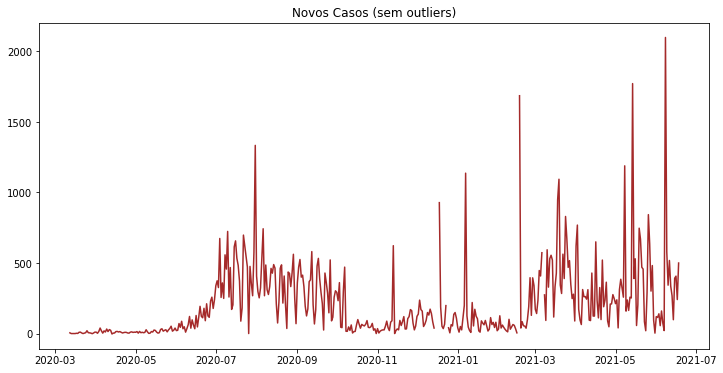

In [208]:
# removendo os outliers, novos casos acima de 2500
df['y'] = ctba['casos_novos'].mask(ctba['casos_novos'] > 2500)
plt.figure(figsize=(12,6))
plt.plot(df['ds'], df['y'], color='brown')
plt.title('Novos Casos (sem outliers)')
plt.show()

Criando e plotando o modelo sem os outliers

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


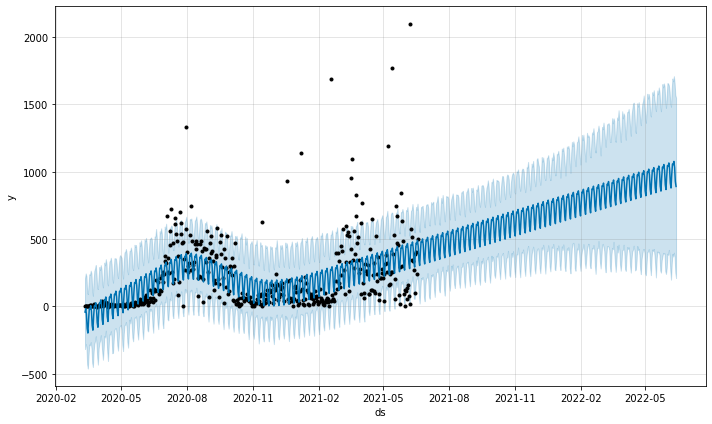

In [209]:
# criar modelo prophet
m = Prophet(changepoint_prior_scale=0.1).fit(df)
future = m.make_future_dataframe(360)
fcst = m.predict(future)
m.plot(fcst);

Esse modelo parece se encaixar mais com o que se espera na realidade e sem muita intervenção externa.

---

Abaixo estou adicionando os feriados do Brasil no modelo.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


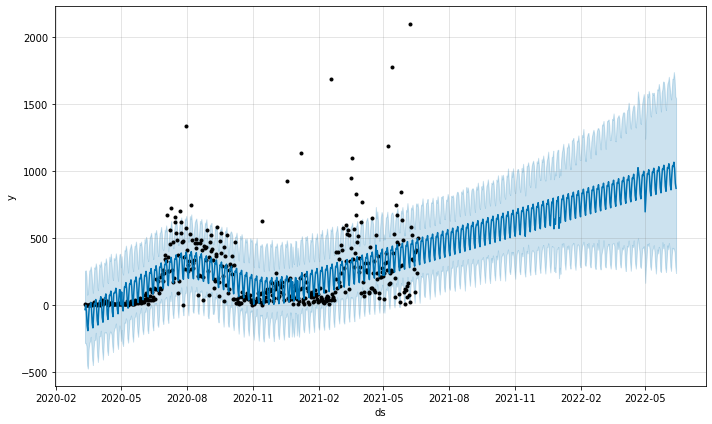

In [210]:
# criar modelo prophet com holidays

m = Prophet(changepoint_prior_scale=0.1)
m.add_country_holidays('BR')
m.fit(df)
future = m.make_future_dataframe(360)
fcst = m.predict(future)
m.plot(fcst);

Abaixo vemos a tendência, a sazonalidade dos feriados (holidays) e a sazonalidade semanal que é levada em conta pelo modelo.

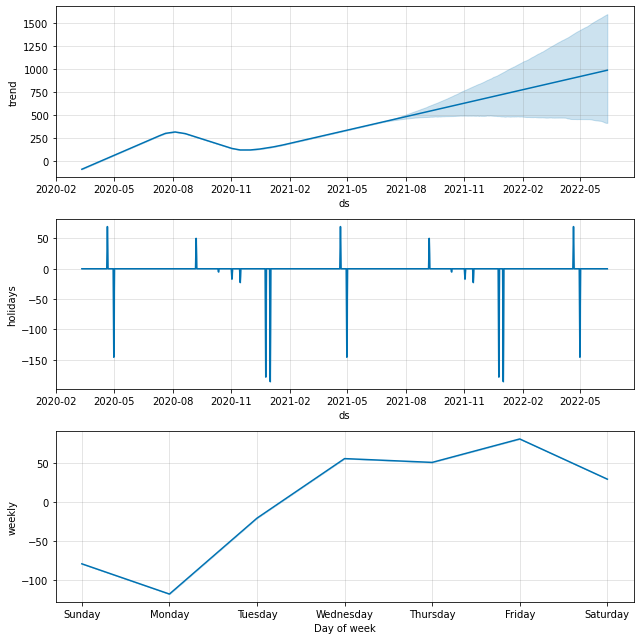

In [211]:
from fbprophet.plot import plot_components
m.plot_components(fcst);

# Adicionando Inverno ao Modelo

Levando em conta na posibilidade de uma aumento do número de casos de covid no inverno devido a baixas temperatura e outros comportamentos que acontecem nessa época, segue a tentativa de criar uma sazonalidade para a época em que ocorre o inverno em Cutiriba.

In [212]:
# funcao checka inverno
def check_inverno(ds):
    '''
    função para identificar os meses de inverno e criar nova coluna com
    True par inverno e False para não inverno.
    '''
    cond = False
    date = pd.to_datetime(ds)
    if date.month == 6 and date.day >= 21:
        cond = True
    if 6 < date.month < 9:
        cond = True
    if date.month == 9 and date.day <= 22:
        cond = True
    return cond

In [213]:
# adiciona datas de inverno no dataframe
df['inverno'] = df['ds'].apply(check_inverno)
df['nao_inverno'] = ~df['ds'].apply(check_inverno)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


116.96981728220935

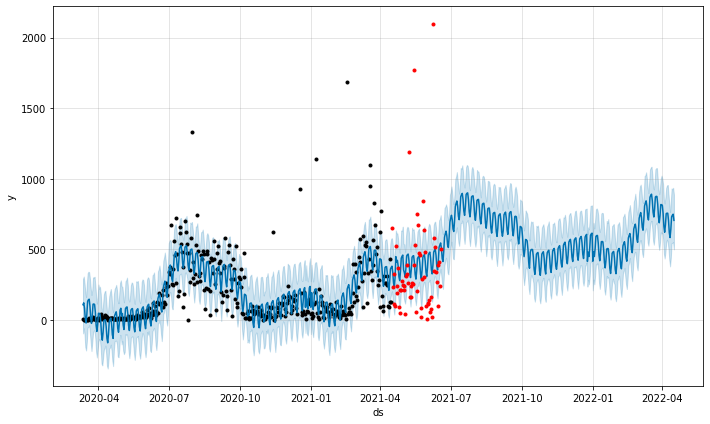

In [214]:
# tentativa com sazonalidade de anual
m = Prophet(yearly_seasonality=True)
m.add_country_holidays('BR')
m.fit(df[:400])
fut = m.make_future_dataframe(366)
fut['inverno'] = fut['ds'].apply(check_inverno)
fut['nao_inverno'] = ~fut['ds'].apply(check_inverno)
fcst = m.predict(fut)
m.plot(fcst);
plt.plot(df['ds'][400:], df['y'][400:], '.r')
resultado = mean_absolute_error(df['y'].fillna(method='bfill'), fcst['yhat'][:464])
resultado

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


128.08713828372734

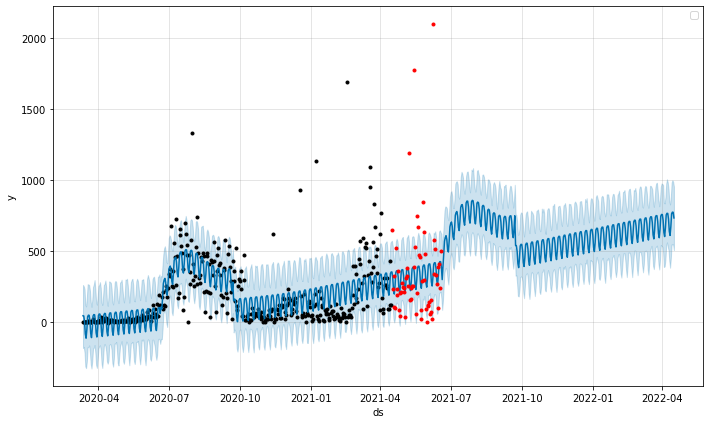

In [215]:
# tentativa com sazonalidade de inverno
m = Prophet(changepoint_prior_scale=0.03)
m.add_seasonality(name='monthly_winter', period=366, fourier_order=3, condition_name='inverno')
m.fit(df[:400])
fut = m.make_future_dataframe(366)
fut['inverno'] = fut['ds'].apply(check_inverno)
fcst = m.predict(fut)
m.plot(fcst);
plt.plot(df['ds'][400:], df['y'][400:], '.r')
plt.legend()
resultado = mean_absolute_error(df['y'].fillna(method='bfill'), fcst['yhat'][:464])
resultado

Removi a sazonalidade semanal para o dados de previsão ficarem melhor para a visualização.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


131.41167280549888

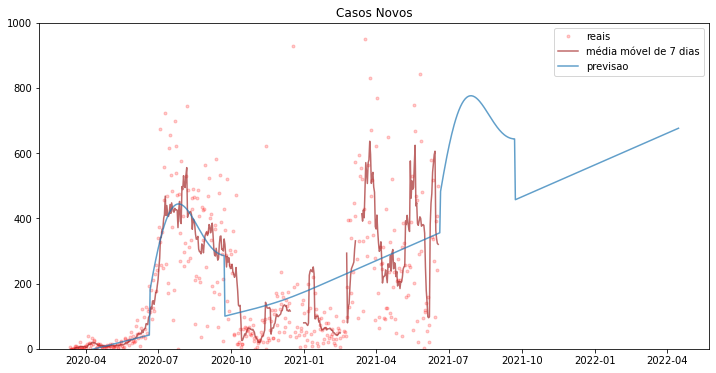

In [216]:
# tentativa com sazonalidade de inverno removi a sazonalidade semanal para comparar com a media movel
m = Prophet(changepoint_prior_scale=0.03, weekly_seasonality=False)
m.add_seasonality(name='monthly_winter', period=366, fourier_order=3, condition_name='inverno')
m.fit(df[:400])
fut = m.make_future_dataframe(366)
fut['inverno'] = fut['ds'].apply(check_inverno)
fut['nao_inverno'] = ~fut['ds'].apply(check_inverno)
fcst = m.predict(fut)
# m.plot(fcst);'
plt.figure(figsize=(12,6))
plt.plot(df['ds'], df['y'], '.r', alpha=0.2, label='reais')
# media movel dos dados no df, ou seja, sem outliers
plt.plot(df['ds'], df['y'].rolling(7).mean(), color='brown', label='média móvel de 7 dias', alpha=0.7) 
plt.plot(fcst['ds'], fcst['yhat'], label='previsao', alpha=0.7)
plt.ylim(0, 1000)
plt.title('Casos Novos')
plt.legend()
resultado = mean_absolute_error(df['y'].fillna(method='bfill'), fcst['yhat'][:464])
resultado

É interessante de ver que a sazonalidade de inverno fica proxima a media movel.

# Testando seasonality_mode: additive | multiplicative

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


127.89381683453183

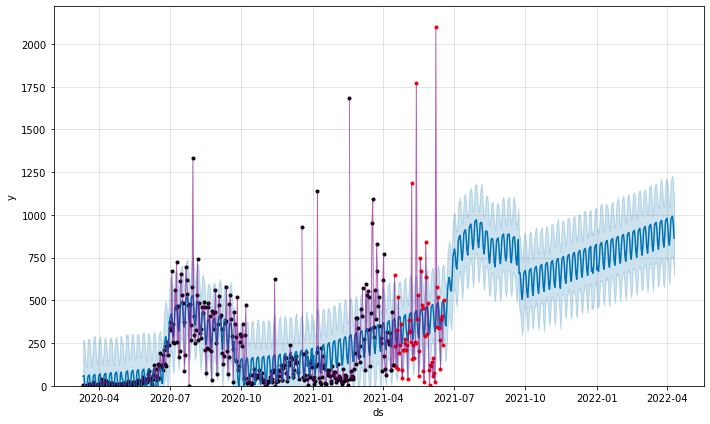

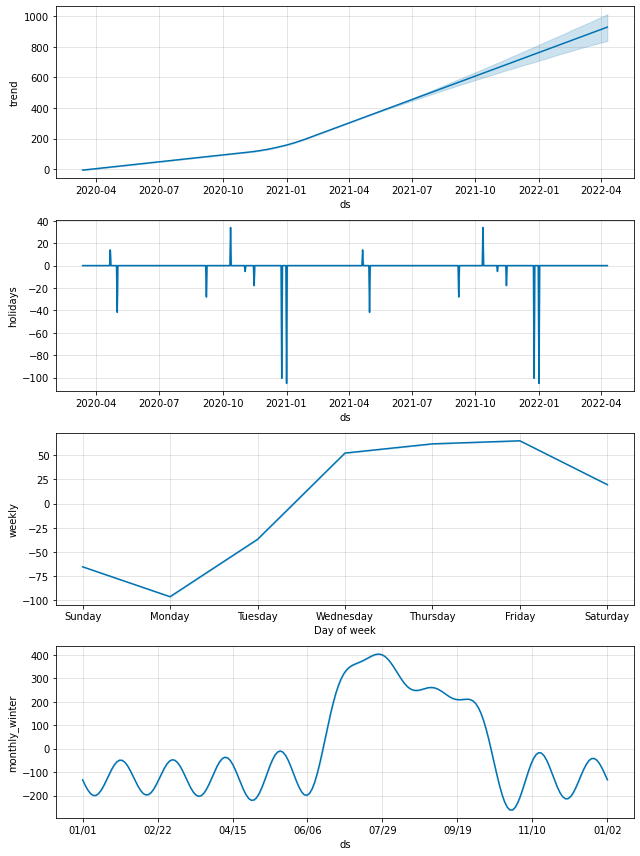

In [217]:
# tentativa com sazonalidade de inverno | seasonality_mode='additive'
m = Prophet()
m.add_seasonality(name='monthly_winter', period=366, fourier_order=10, condition_name='inverno')
m.add_country_holidays('BR')
m.fit(df[:400])
fut = m.make_future_dataframe(360)
fut['inverno'] = fut['ds'].apply(check_inverno)
fcst = m.predict(fut)
m.plot(fcst);
plt.plot(df['ds'][400:], df['y'][400:], '.r')
plt.plot(df['ds'], df['y'], color='purple', alpha=0.6, label='reais', linewidth=1)
plt.ylim(0)
m.plot_components(fcst);
resultado_additive = mean_absolute_error(df['y'].fillna(method='bfill'), fcst['yhat'][:464])
resultado_additive

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


122.81300970176746

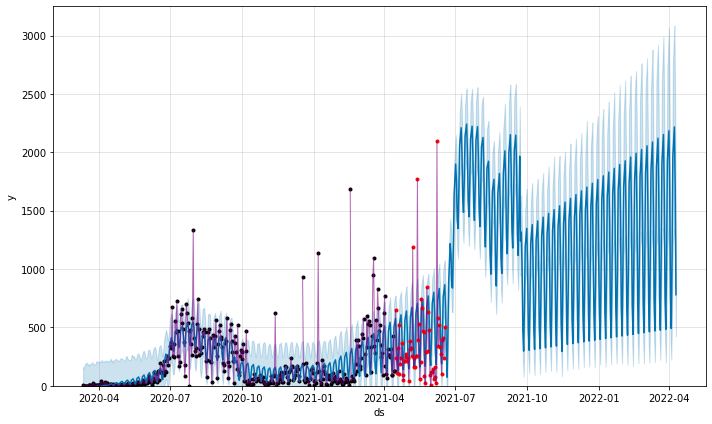

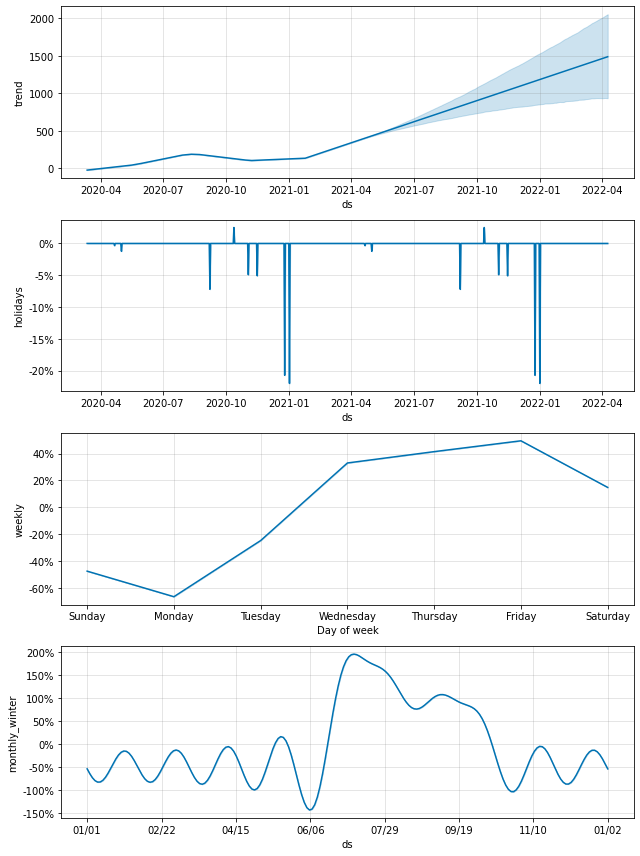

In [218]:
# tentativa com sazonalidade de inverno | seasonality_mode='multiplicative'
m = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.2)

# adiciona sazonalidade pra quando é inverno (fiquei com muita duvida em relação ao periodo)
m.add_seasonality(name='monthly_winter', period=366, fourier_order=10, condition_name='inverno')
# resolvi tirar quando NÃO é inverno
# m.add_seasonality(name='monthly_not_winter', period=366, fourier_order=10, condition_name='nao_inverno')

# adiciona feriados
m.add_country_holidays('BR')

# treina o modelo, com os dados até 400 para treino
m.fit(df[:400])

# dataframe futuro para 1 ano
fut = m.make_future_dataframe(360)

# adiciona datas de inverno no futuro
fut['inverno'] = fut['ds'].apply(check_inverno)
fut['nao_inverno'] = ~fut['ds'].apply(check_inverno)

# faz a previsao
fcst = m.predict(fut)

# plota graficos de previsão e os dados de teste em vermelho
m.plot(fcst);
plt.plot(df['ds'][400:], df['y'][400:], '.r')
plt.plot(df['ds'], df['y'], color='purple', alpha=0.6, label='reais', linewidth=1)
plt.ylim(0)

# plota os componentes da previsao (tendencias e sazonalidades)
m.plot_components(fcst);

# calculado o resultado de error
resultado_multiplicative = mean_absolute_error(df['y'].fillna(method='bfill'), fcst['yhat'][:464])
resultado_multiplicative

Comparando os resultados

In [219]:
print(f'additive: {resultado_additive} \nmultiplicative: {resultado_multiplicative}')

additive: 127.89381683453183 
multiplicative: 122.81300970176746


# CONTEUDO DO BOOTCAMP - EM PROCESSO

In [220]:
novo_y = df.reset_index()

In [221]:
len(df)

464

In [222]:
sem_outliers = novo_y[(novo_y['y'] > fcst['yhat_lower'][:len(df)]) & (novo_y['y'] < fcst['yhat_upper'][:len(df)])] 
sem_outliers.head()

,index,ds,y,inverno,nao_inverno
0,1300681,2020-03-12,5.0,False,True
1,1300684,2020-03-13,0.0,False,True
2,1300687,2020-03-14,0.0,False,True
3,1300690,2020-03-15,0.0,False,True
4,1300693,2020-03-16,0.0,False,True


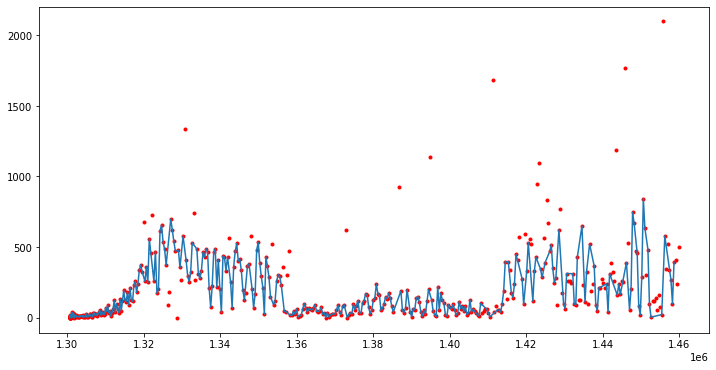

In [223]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['y'], 'r.')
plt.plot(sem_outliers['index'], sem_outliers['y'])

In [224]:
df_sem_outliers = sem_outliers[['ds', 'y']]
df_sem_outliers['inverno'] = df_sem_outliers['ds'].apply(check_inverno)
df_sem_outliers.head()

,ds,y,inverno
0,2020-03-12,5.0,False
1,2020-03-13,0.0,False
2,2020-03-14,0.0,False
3,2020-03-15,0.0,False
4,2020-03-16,0.0,False


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


50.500015922049236

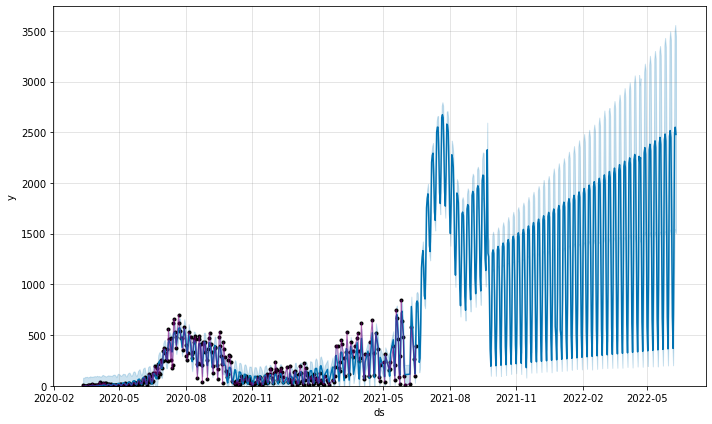

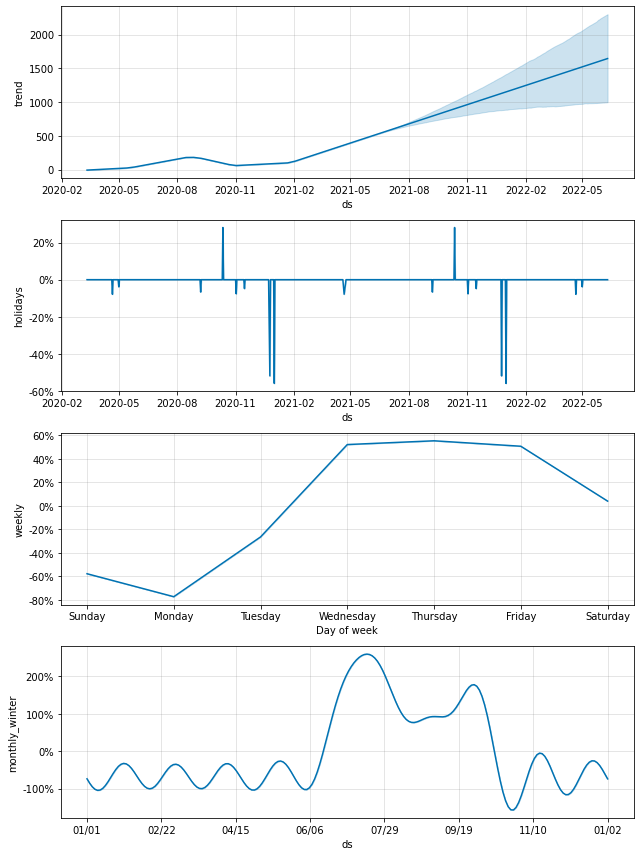

In [225]:
# tentativa com sazonalidade de inverno | seasonality_mode='multiplicative'
m = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.2)

# adiciona sazonalidade pra quando é inverno (fiquei com muita duvida em relação ao periodo)
m.add_seasonality(name='monthly_winter', period=366, fourier_order=10, condition_name='inverno')
# resolvi tirar quando NÃO é inverno
# m.add_seasonality(name='monthly_not_winter', period=366, fourier_order=10, condition_name='nao_inverno')

# adiciona feriados
m.add_country_holidays('BR')

# treina o modelo, com os dados até 400 para treino
m.fit(df_sem_outliers[:400])

# dataframe futuro para 1 ano
fut = m.make_future_dataframe(360)

# adiciona datas de inverno no futuro
fut['inverno'] = fut['ds'].apply(check_inverno)
# fut['nao_inverno'] = ~fut['ds'].apply(check_inverno)

# faz a previsao
fcst = m.predict(fut)

# plota graficos de previsão e os dados de teste em vermelho
m.plot(fcst);
plt.plot(df_sem_outliers['ds'][400:], df_sem_outliers['y'][400:], '.r')
plt.plot(df_sem_outliers['ds'], df_sem_outliers['y'], color='purple', alpha=0.6, label='reais', linewidth=1)
plt.ylim(0)

# plota os componentes da previsao (tendencias e sazonalidades)
m.plot_components(fcst);

# calculado o resultado de error
resultado_multiplicative = mean_absolute_error(df_sem_outliers['y'].fillna(method='bfill'), fcst['yhat'][:len(df_sem_outliers)])
resultado_multiplicative

In [226]:
fcst['inverno'] =  fcst['ds'].apply(check_inverno)
amostras = m.predictive_samples(fcst)

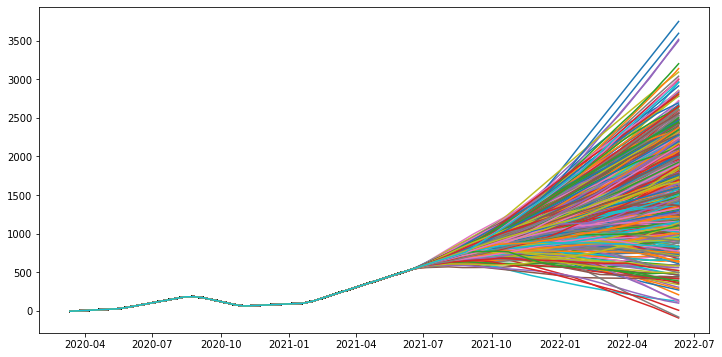

In [227]:
plt.figure(figsize=(12,6))
fig = plt.plot(fcst['ds'], amostras['trend'])
plt.show()

In [228]:
# df_cv = cross_validation(m, initial='180 days', period='30 days', horizon='30 days' )
